**Importing Libraries** and **Installing Dependencies**

In [20]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Importing Datasets**

In [21]:
dataset = yf.download("GC=F", start="2019-01-01", end="2023-07-19")
dataset

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...
2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951,1956.199951,132
2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951,1959.199951,121
2023-07-14,1958.400024,1960.599976,1952.699951,1960.099976,1960.099976,94


**Dropping Unused Column / Data Reduction**

In [22]:
dataReduct = dataset
to_drop = ['Open', 'High', 'Low',	'Adj Close', 'Volume']
dataReduct.drop(to_drop, inplace=True, axis=1)
dataReduct

,Close
Date,
2019-01-02,1281.000000
2019-01-03,1291.800049
2019-01-04,1282.699951
2019-01-07,1286.800049
2019-01-08,1283.199951
...,...
2023-07-12,1956.199951
2023-07-13,1959.199951
2023-07-14,1960.099976


In [23]:
df = pd.DataFrame(dataReduct)
df.to_csv('data aktual.csv', index=False)

**Normalize Data**

In [24]:
dataReduct = dataReduct.values
scaler = MinMaxScaler()
dataScaled = scaler.fit_transform(dataReduct)
dataScaled

array([[0.01495775],
       [0.02876502],
       [0.01713104],
       ...,
       [0.88315005],
       [0.87330608],
       [0.90501144]])

Create **Data Train** and **Data Test** to separate them to make the model

In [25]:
time_steps = 1 # How many days are used to look back for predict the next day

training_data_len = math.ceil(len(dataReduct) * .8) # Length Data

data_train = dataScaled[0:training_data_len, :]
data_test = dataScaled[training_data_len - time_steps: , :]

X_train = []
y_train = []

Nilai_prediksi = []
Nilai_aktual = dataReduct[training_data_len:, :]

for i in range(time_steps, len(data_train)):
  X_train.append(data_train[i-time_steps:i, 0])
  y_train.append(data_train[i, 0])

for i in range(time_steps, len(data_test)):
  Nilai_prediksi.append(data_test[i-time_steps:i, 0])

**Convert** data to numpy array and **Reshaping** a NumPy array with 1 feature.

In [26]:
features = 1 # column

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], features))

Nilai_prediksi = np.array(Nilai_prediksi)
Nilai_prediksi = np.reshape(Nilai_prediksi, (Nilai_prediksi.shape[0], Nilai_prediksi.shape[1], features))

In [27]:
X_train.shape

(914, 1, 1)

In [28]:
Nilai_prediksi.shape

(228, 1, 1)

In [29]:
tf.random.set_seed(10)

Model **LSTM** & **Bi-LSTM** and **Evaluation + Output**

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

outputs_rmse_lstm = []
outputs_mape_lstm = []
outputs_r_squared_lstm = []
outputs_rmse_bilstm = []
outputs_mape_bilstm = []
outputs_r_squared_bilstm = []

validation_lstm_list = []
validation_bilstm_list = []

for _ in range(5):
    # LSTM Model
    model_lstm = Sequential([(layers.LSTM(50)), layers.Dense(25),
                              layers.Dense(1)])

    model_lstm.compile(loss='mse', optimizer=Adam())
    model_lstm.fit(X_train, y_train, epochs=1, batch_size=1)

    # Bi-LSTM Model
    model_bilstm = Sequential([layers.Bidirectional(layers.LSTM(50)), layers.Dense(25),
                          layers.Dense(1)])

    model_bilstm.compile(loss='mse', optimizer=Adam())
    model_bilstm.fit(X_train, y_train, epochs=1, batch_size = 1)

    # Evaluate & Denormalization LSTM and Bi-LSTM
    result_lstm = model_lstm.evaluate(Nilai_prediksi, Nilai_aktual)
    Predictions_lstm = model_lstm.predict(Nilai_prediksi)
    Predictions_lstm = scaler.inverse_transform(Predictions_lstm)

    result_bilstm = model_bilstm.evaluate(Nilai_prediksi, Nilai_aktual)
    Predictions_bilstm = model_bilstm.predict(Nilai_prediksi)
    Predictions_bilstm = scaler.inverse_transform(Predictions_bilstm)

    # Evaluate each model performance to RMSE, MAPE, and R-squared
    rmse_lstm = np.sqrt(mean_squared_error(Nilai_aktual, Predictions_lstm))
    mape_lstm = mean_absolute_percentage_error(Nilai_aktual, Predictions_lstm)
    r_squared_lstm = r2_score(Nilai_aktual, Predictions_lstm)

    rmse_bilstm = np.sqrt(mean_squared_error(Nilai_aktual, Predictions_bilstm))
    mape_bilstm = mean_absolute_percentage_error(Nilai_aktual, Predictions_bilstm)
    r_squared_bilstm = r2_score(Nilai_aktual, Predictions_bilstm)

    # Output each model performance
    outputs_rmse_lstm.append(rmse_lstm)
    outputs_mape_lstm.append(mape_lstm)
    outputs_r_squared_lstm.append(r_squared_lstm)

    outputs_rmse_bilstm.append(rmse_bilstm)
    outputs_mape_bilstm.append(mape_bilstm)
    outputs_r_squared_bilstm.append(r_squared_bilstm)

    # Visualization Plot using Line Graph
    validation_lstm = dataset[training_data_len:]
    validation_lstm['Predictions_lstm'] = Predictions_lstm
    validation_bilstm = dataset[training_data_len:]
    validation_bilstm['Predictions_bilstm'] = Predictions_bilstm

    validation_lstm_list.append(validation_lstm)
    validation_bilstm_list.append(validation_bilstm)

8/8 [==============================] - 1s 3ms/step


<ipython-input-30-26748618746c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_lstm['Predictions_lstm'] = Predictions_lstm
<ipython-input-30-26748618746c>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_bilstm['Predictions_bilstm'] = Predictions_bilstm


8/8 [==============================] - 1s 4ms/step


<ipython-input-30-26748618746c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_lstm['Predictions_lstm'] = Predictions_lstm
<ipython-input-30-26748618746c>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_bilstm['Predictions_bilstm'] = Predictions_bilstm


8/8 [==============================] - 1s 3ms/step


<ipython-input-30-26748618746c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_lstm['Predictions_lstm'] = Predictions_lstm
<ipython-input-30-26748618746c>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_bilstm['Predictions_bilstm'] = Predictions_bilstm


8/8 [==============================] - 1s 3ms/step


<ipython-input-30-26748618746c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_lstm['Predictions_lstm'] = Predictions_lstm
<ipython-input-30-26748618746c>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_bilstm['Predictions_bilstm'] = Predictions_bilstm


8/8 [==============================] - 1s 3ms/step


<ipython-input-30-26748618746c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_lstm['Predictions_lstm'] = Predictions_lstm
<ipython-input-30-26748618746c>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_bilstm['Predictions_bilstm'] = Predictions_bilstm


In [31]:
# Output each model performance with 5 tries
n = 1
t = 1
for x,y,z in zip(outputs_rmse_lstm, outputs_mape_lstm, outputs_r_squared_lstm):
  print("RMSE LSTM Pengujian", n, " :", x)
  print("MAPE LSTM Pengujian", n, " :", y)
  print("R_squared LSTM Pengujian", n, " :", z, "\n")
  n += 1

for x,y,z in zip(outputs_rmse_bilstm, outputs_mape_bilstm, outputs_r_squared_bilstm):
  print("RMSE Bi-LSTM Pengujian", t, " :", x)
  print("MAPE Bi-LSTM Pengujian", t, " :", y)
  print("R_squared Bi-LSTM Pengujian", t, " :", z, "\n")
  t += 1

RMSE LSTM Pengujian 1  : 25.47781476866975
MAPE LSTM Pengujian 1  : 0.011491309319335381
R_squared LSTM Pengujian 1  : 0.9559592533078018 

RMSE LSTM Pengujian 2  : 25.87833623522128
MAPE LSTM Pengujian 2  : 0.01166096508546325
R_squared LSTM Pengujian 2  : 0.9545636930707491 

RMSE LSTM Pengujian 3  : 25.616209872040088
MAPE LSTM Pengujian 3  : 0.01157793794063007
R_squared LSTM Pengujian 3  : 0.9554794964852813 

RMSE LSTM Pengujian 4  : 26.487561761156837
MAPE LSTM Pengujian 4  : 0.012092629946141855
R_squared LSTM Pengujian 4  : 0.9523991961668019 

RMSE LSTM Pengujian 5  : 24.802305928300928
MAPE LSTM Pengujian 5  : 0.011247820965188542
R_squared LSTM Pengujian 5  : 0.9582636522675154 

RMSE Bi-LSTM Pengujian 1  : 28.54239375817328
MAPE Bi-LSTM Pengujian 1  : 0.013416476213320552
R_squared Bi-LSTM Pengujian 1  : 0.9447272454648783 

RMSE Bi-LSTM Pengujian 2  : 28.04644319872621
MAPE Bi-LSTM Pengujian 2  : 0.013155832126839118
R_squared Bi-LSTM Pengujian 2  : 0.9466313880883175 

R

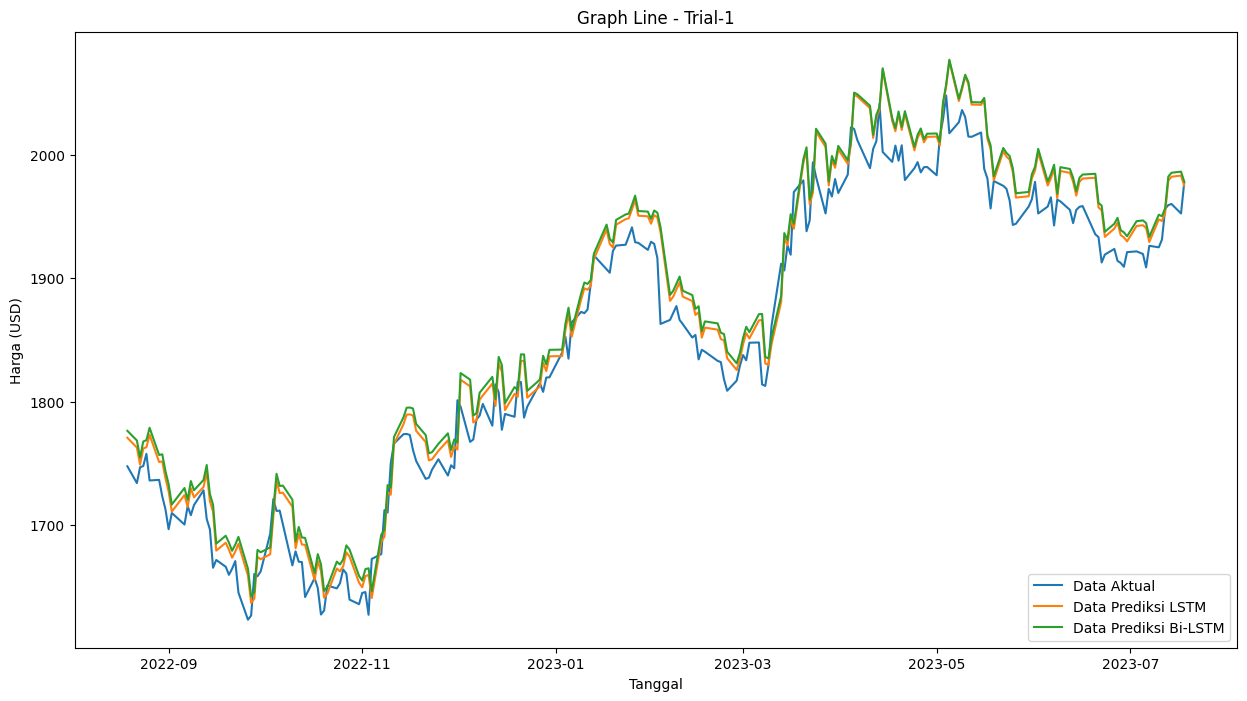

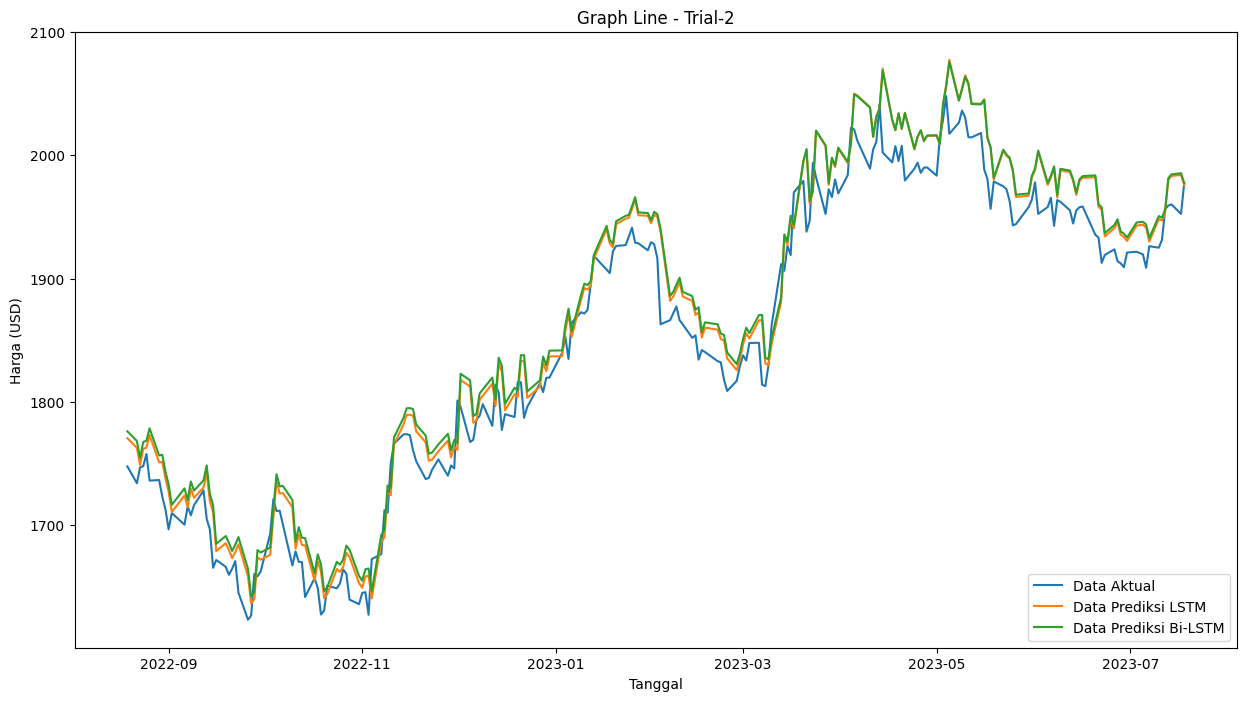

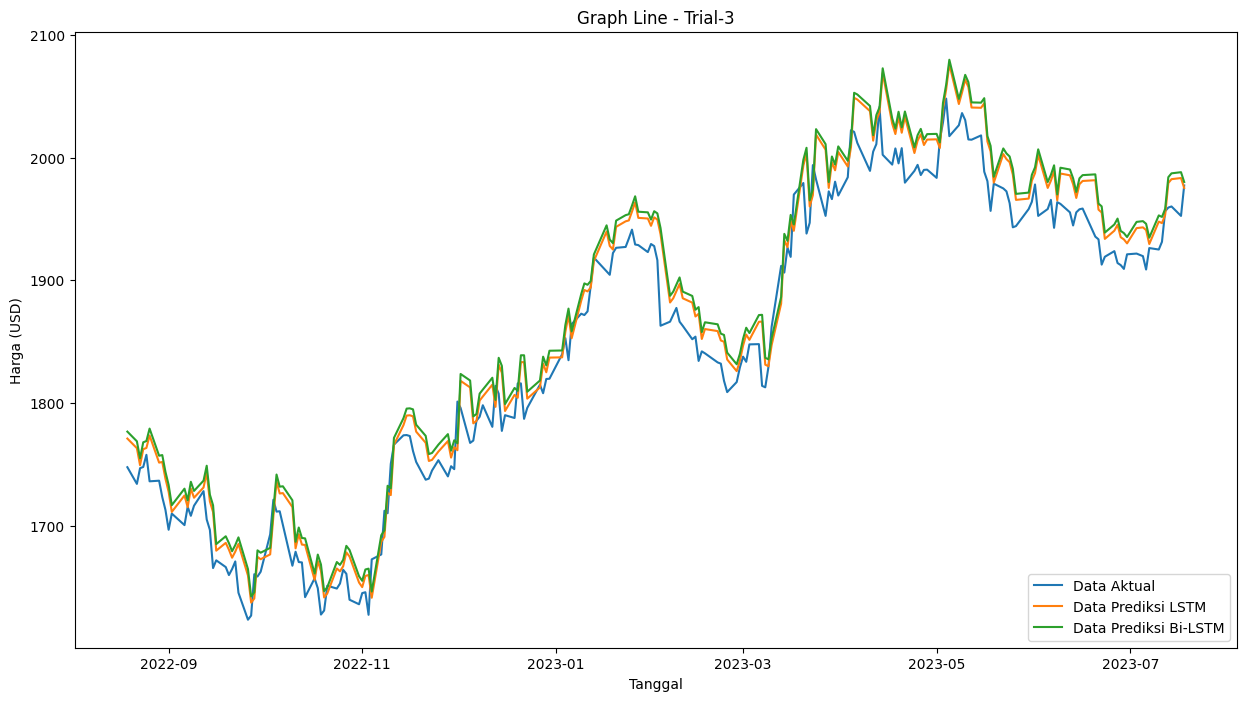

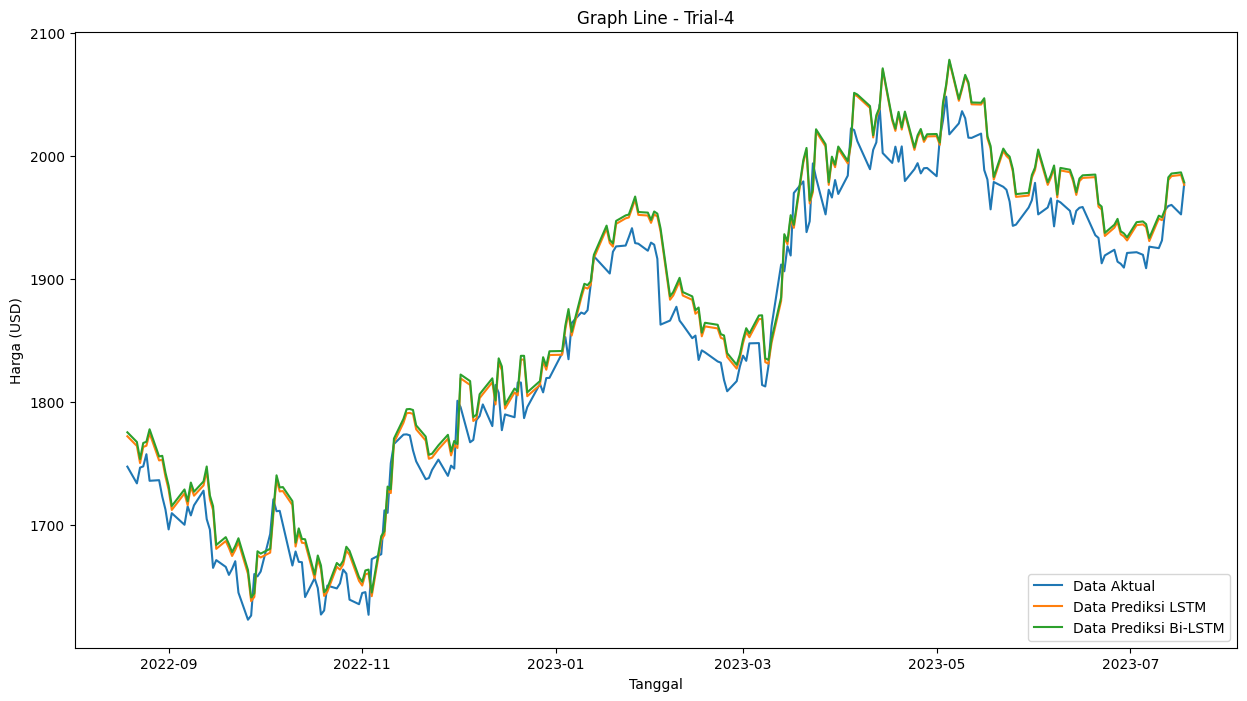

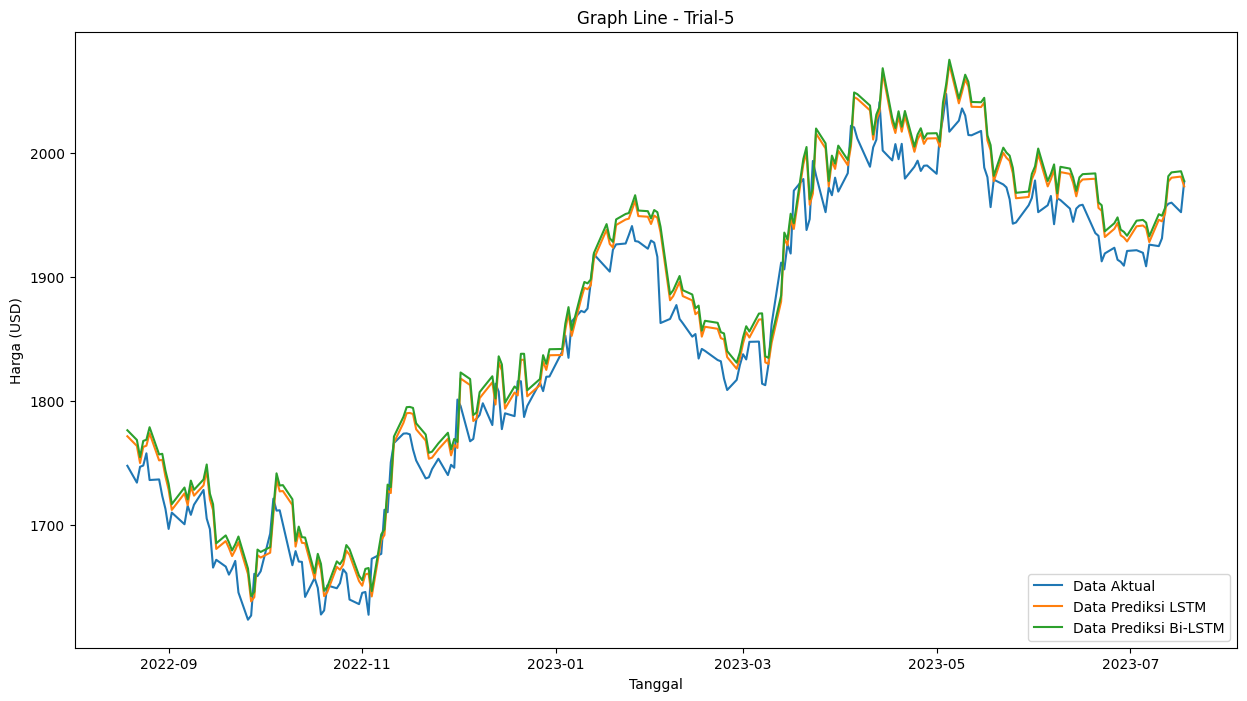

In [32]:
# Plot Visualization with 5 tries
n = 1
for df_lstm, df_bilstm in zip(validation_lstm_list, validation_bilstm_list):
    plt.figure(figsize=(15, 8))
    plt.title(f'Graph Line - Trial-{n}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (USD)')

    # Plot actual data, LSTM predictions, and Bi-LSTM predictions
    plt.plot(df_lstm.iloc[:][['Close', 'Predictions_lstm']])
    plt.plot(df_bilstm.iloc[:][['Predictions_bilstm' ]])
    plt.legend(['Data Aktual', 'Data Prediksi LSTM', 'Data Prediksi Bi-LSTM'], loc='lower right')
    plt.show()

    n += 1

In [33]:
df_lstm.iloc[:][['Close', 'Predictions_lstm']]

,Close,Predictions_lstm
Date,,
2022-08-19,1747.599976,1771.457886
2022-08-22,1734.000000,1763.635376
2022-08-23,1746.800049,1749.831299
2022-08-24,1747.800049,1762.822998
2022-08-25,1757.699951,1763.838379
...,...,...
2023-07-12,1956.199951,1951.508057
2023-07-13,1959.199951,1977.149414
2023-07-14,1960.099976,1980.241211


Output Summary **Layers** and **Models** (LSTM)

In [34]:
print(model_lstm.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 50)                10400     
                                                                 
 dense_52 (Dense)            (None, 25)                1275      
                                                                 
 dense_53 (Dense)            (None, 1)                 26        
                                                                 
Total params: 11701 (45.71 KB)
Trainable params: 11701 (45.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Output Summary **Layers** and **Models** (Bi-LSTM)

In [35]:
print(model_bilstm.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirect  (None, 100)               20800     
 ional)                                                          
                                                                 
 dense_54 (Dense)            (None, 25)                2525      
                                                                 
 dense_55 (Dense)            (None, 1)                 26        
                                                                 
Total params: 23351 (91.21 KB)
Trainable params: 23351 (91.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
